In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ExifTags
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

torch.backends.cudnn.benchmark = True

In [9]:
def extractCoordinates(image_path):
    img = Image.open(image_path)
    exif_data = img._getexif()
    if not exif_data:
        return None

    gps_info = {}
    for tag, value in exif_data.items():
        decoded = ExifTags.TAGS.get(tag, tag)
        if decoded == "GPSInfo":
            # Map the inner GPS tags (e.g., 1: 'GPSLatitudeRef', 2: 'GPSLatitude'...)
            for t in value:
                sub_decoded = ExifTags.GPSTAGS.get(t, t)
                gps_info[sub_decoded] = value[t]

    # If GPS data exists, calculate the decimals
    if "GPSLatitude" in gps_info and "GPSLongitude" in gps_info:
        lat_dms = gps_info["GPSLatitude"]
        lat_ref = gps_info["GPSLatitudeRef"]
        lon_dms = gps_info["GPSLongitude"]
        lon_ref = gps_info["GPSLongitudeRef"]

        # Helper to convert DMS to Decimal
        def dms_to_decimal(dms, ref):
            # dms is a list of 3 rationals [(deg_num, deg_den), (min, den), (sec, den)]
            deg = float(dms[0])
            minute = float(dms[1])
            sec = float(dms[2])

            decimal = deg + (minute / 60.0) + (sec / 3600.0)
            if ref in ['S', 'W']:
                decimal = -decimal
            return decimal

        lat = dms_to_decimal(lat_dms, lat_ref)
        lon = dms_to_decimal(lon_dms, lon_ref)

        return lat, lon

    return None


In [10]:
def haversine_distance(coord1, coord2):
    """
    Calculates the distance in meters between two points on the earth.
    Input: Arrays of [Latitude, Longitude]
    """
    # Earth's radius in meters
    R = 6371000.0 
    
    # Convert degrees to radians
    lat1, lon1 = np.radians(coord1[:, 0]), np.radians(coord1[:, 1])
    lat2, lon2 = np.radians(coord2[:, 0]), np.radians(coord2[:, 1])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [11]:
class GeolocalizationDataset(Dataset):
  def __init__(self, image_paths, coordinates, use_dropout=False, use_dropout2d=False, is_train =False):
        self.image_paths = image_paths
        self.coordinates = coordinates

        transformations = [T.Resize((256, 192))]

        if is_train == True:
            transformations.append(T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5))
            transformations.append(T.RandomGrayscale(p=0.2))
            

        transformations.extend([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.transform = T.Compose(transformations)


  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self, idx):
        # 1. Load the image using the path from our list
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # 2. Apply the vertical-to-square transform
        image = self.transform(image)

        # 3. Get the pre-extracted (and scaled) coordinate
        coord = torch.tensor(self.coordinates[idx], dtype=torch.float32)

        return image, coord



In [12]:
class ConvNet(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()

        self.use_dropout = use_dropout
        self.use_dropout2d = use_dropout2d

        self.conv1 = nn.Conv2d(3, 128, 5, padding='same')
        self.conv2 = nn.Conv2d(128, 64, 3, padding='same')

        if self.use_dropout2d:
            self.spatial_dropout = nn.Dropout2d(p=0.2)

        # Global Average Pooling ensures this stays 64 regardless of image size
        self.fc1 = nn.Linear(64, 256)

        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)

        # 2. Vector of 2 for [Latitude, Longitude]
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.conv2(x)

        if self.use_dropout2d:
            x = self.spatial_dropout(x)

        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1) # Global Avg Pool
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)

        x = self.fc2(x) # Linear output for regression
        return x

In [13]:
class ConvNet2(nn.Module):
    def __init__(self, use_dropout=True):
        super(ConvNet2, self).__init__()

        # Layer 1: 3 -> 32 filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Stabilizes learning
        
        # Layer 2: 32 -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Layer 3: 64 -> 128 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Layer 4: 128 -> 256 filters
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(512, 2) # [Latitude, Longitude]

    def forward(self, x):
        # Conv Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) # 256 -> 128
        
        # Conv Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2) # 128 -> 64
        
        # Conv Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2) # 64 -> 32
        
        # Conv Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.adaptive_avg_pool2d(x, 1) # Global Average Pooling
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Training on 680 images, Validating on 170 images.
Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 SUPER
Starting training on cuda...
Epoch [1/20]
  -> Loss (MSE): Train 0.098558 | Val 0.075591
  -> Reality: Avg Error 82.7m | Accuracy@50m: 34.7%
------------------------------
  *** NEW BEST: 82.7m ***
------------------------------
Epoch [2/20]
  -> Loss (MSE): Train 0.082395 | Val 0.069454
  -> Reality: Avg Error 78.7m | Accuracy@50m: 34.7%
------------------------------
  *** NEW BEST: 78.7m ***
------------------------------
Epoch [3/20]
  -> Loss (MSE): Train 0.080976 | Val 0.071778
  -> Reality: Avg Error 82.2m | Accuracy@50m: 30.6%
------------------------------
  (No improvement for 1/8 epochs)
------------------------------
Epoch [4/20]
  -> Loss (MSE): Train 0.079423 | Val 0.068564
  -> Reality: Avg Error 79.9m | Accuracy@50m: 31.2%
------------------------------
  (No improvement for 2/8 epochs)
------------------------------
Epoch [5/20]
  -> Loss (MSE): 

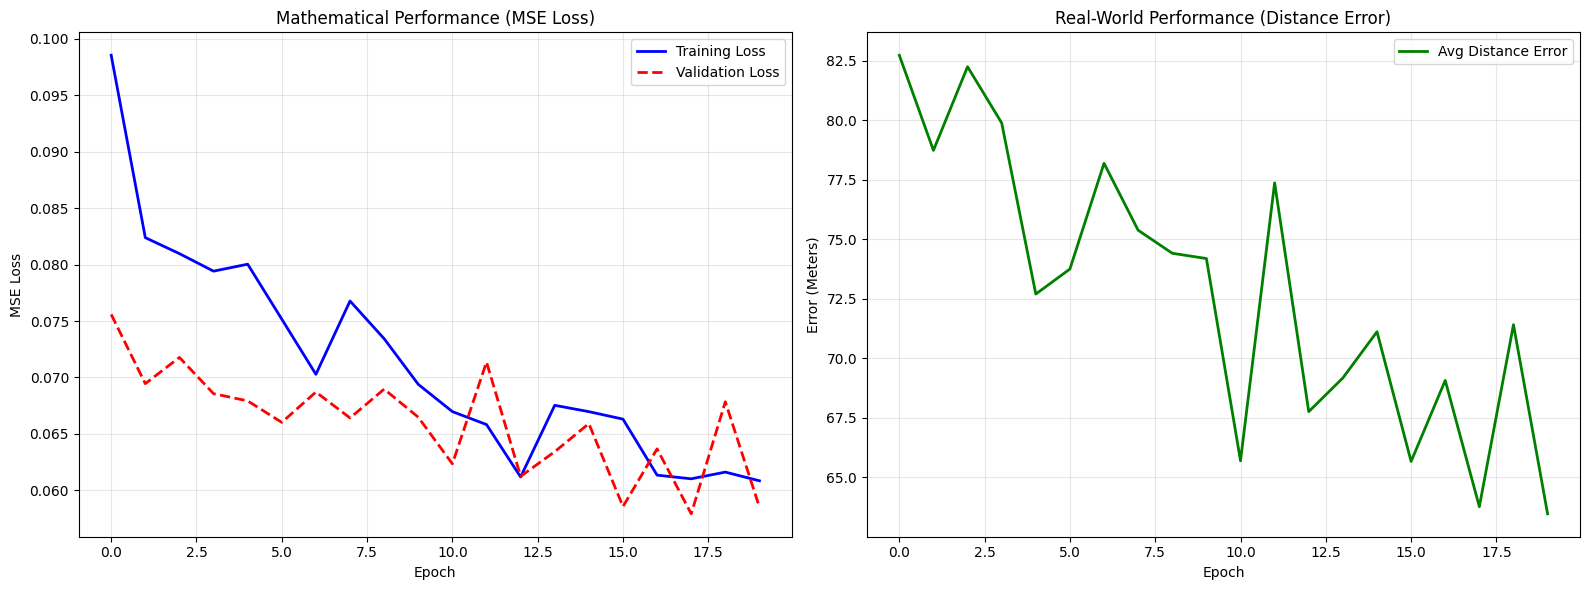


Training finished! Best Validation Error: 63.5 meters.
Model saved as 'geo_model.pth'


In [14]:
if __name__ == "__main__":

    # --- 1. SETUP PATHS ---
    IMAGE_FOLDER = r"C:\Users\Tal Sch\Desktop\Project"
    SCALER_SAVE_PATH = 'coordinate_scaler.pkl'

    # --- 2. EXTRACTION PHASE ---
    raw_data = []
    for filename in os.listdir(IMAGE_FOLDER):
        if filename.lower().endswith(('.jpg', '.jpeg')):
            full_path = os.path.join(IMAGE_FOLDER, filename)
            coords = extractCoordinates(full_path)
            if coords:
                raw_data.append({'path': full_path, 'lat': coords[0], 'lon': coords[1]})

    df = pd.DataFrame(raw_data)

    # --- 3. SCALING PHASE ---
    scaler = MinMaxScaler()
    df[['lat', 'lon']] = scaler.fit_transform(df[['lat', 'lon']])
    joblib.dump(scaler, SCALER_SAVE_PATH)

    # Keep 20% of the data for validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- 4. DATASET INITIALIZATION ---
    train_dataset = GeolocalizationDataset(
        image_paths=train_df['path'].tolist(),
        coordinates=train_df[['lat', 'lon']].values,
        is_train=True
    )

    val_dataset = GeolocalizationDataset(
        image_paths=val_df['path'].tolist(),
        coordinates=val_df[['lat', 'lon']].values,
        is_train=False
    )

    # --- 5. THE DATALOADER ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,
        pin_memory=True)
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=False)

    print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images.")

    # --- 6. INITIALIZE MODEL ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ConvNet2(use_dropout=True).to(device)
    print("Using device:", device)
    print("CUDA available:", torch.cuda.is_available())
    print("GPU:", torch.cuda.get_device_name(0))


    # --- 7. LOSS & OPTIMIZER ---
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # --- 8. TRAINING & VALIDATION LOOP ---
    train_losses = []
    val_losses = []
    val_dist_history = []
    best_dist = float('inf')
    patience_counter = 0
    early_stopping_patience = 8
    epochs = 20
    print(f"Starting training on {device}...")

    for epoch in range(epochs):
        # --- PHASE 1: TRAINING ---
        model.train() # Dropout ON
        train_running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

        # --- PHASE 2: VALIDATION ---
        model.eval() # Set model to evaluation mode (disables Dropout)
        val_running_loss = 0.0
        total_distance = 0.0
        correct_50m = 0
        total_samples = 0
        
        with torch.no_grad(): # Disable gradient calculation for efficiency
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # 1. Standard Prediction and MSE Loss
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                
                # 2. Get Real-World Coordinates for Physical Metrics
                # Convert normalized predictions and labels back to GPS
                pred_normalized = outputs.cpu().numpy()
                true_normalized = labels.cpu().numpy()
                
                real_preds = scaler.inverse_transform(pred_normalized) #
                real_trues = scaler.inverse_transform(true_normalized) #
                
                # 3. Calculate Physical Distance Error
                distances = haversine_distance(real_preds, real_trues)
                
                # 4. Accumulate Statistics
                total_distance += np.sum(distances)
                correct_50m += np.sum(distances < 50) # Count hits within 50m
                total_samples += len(labels)

        # --- PHASE 3: METRICS CALCULATION & PRINTING ---
        avg_train_loss = train_running_loss / len(train_loader)
        avg_val_loss = val_running_loss / len(val_loader)
        
        # Physical Metrics
        avg_dist_error = total_distance / total_samples # Average error in meters
        accuracy_50m = (correct_50m / total_samples) * 100 # % Success rate

        # Keep history for plots
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_dist_history.append(avg_dist_error)

        # Log results
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"  -> Loss (MSE): Train {avg_train_loss:.6f} | Val {avg_val_loss:.6f}")
        print(f"  -> Reality: Avg Error {avg_dist_error:.1f}m | Accuracy@50m: {accuracy_50m:.1f}%")
        print("-" * 30)

        # -- SCHEDULER --
        # 1. Step the scheduler based on physical error
        scheduler.step(avg_dist_error)
        
        # 2. Save the BEST version of YOUR model
        if avg_dist_error < best_dist:
            best_dist = avg_dist_error
            torch.save(model.state_dict(), 'custom_geo_model_best.pth')
            patience_counter = 0 
            print(f"  *** NEW BEST: {best_dist:.1f}m ***")
        else:
            patience_counter += 1
            print(f"  (No improvement for {patience_counter}/{early_stopping_patience} epochs)")
            
        print("-" * 30)

        # 3. Early Stopping check
        if patience_counter >= early_stopping_patience:
            print("Model stopped improving. Ending training early.")
            break

    # --- 9. SAVE THE MODEL & GENERATE PLOTS ---

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left Plot: MSE Loss (Training vs Validation)
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)
    ax1.set_title('Mathematical Performance (MSE Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Right Plot: Physical Distance Error (Meters)
    ax2.plot(val_dist_history, label='Avg Distance Error', color='green', linewidth=2)
    ax2.set_title('Real-World Performance (Distance Error)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error (Meters)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Save the model weights
    torch.save(model.state_dict(), 'geo_model.pth')
    print(f"\nTraining finished! Best Validation Error: {best_dist:.1f} meters.")
    print("Model saved as 'geo_model.pth'")


In [ ]:

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER_PATH = 'coordinate_scaler.pkl'
MODEL_WEIGHTS_PATH = 'geo_model.pth'

# Loading Model and Scaler
# Initialize the model architecture and move to the device (GPU/CPU)
model = ConvNet().to(device)

# Load the trained weights from the .pth file
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

# Set the model to evaluation mode (disables Dropout and Batchnorm layers)
model.eval()

# Load the MinMaxScaler used during training to reverse the normalization
scaler = joblib.load(SCALER_PATH)

# Image Preprocessing Function
def predict_location(image_path):

    # Load the image and ensure it is in RGB format
    img = Image.open(image_path).convert('RGB')
    
    # Apply the same validation transforms (No augmentations here!)
    preprocess = T.Compose([
        T.Resize(256),
        T.CenterCrop(256),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Add a batch dimension (Batch size of 1) and move the tensor to device
    img_tensor = preprocess(img).unsqueeze(0).to(device) 
    
    # Perform inference without calculating gradients
    with torch.no_grad():
        output = model(img_tensor)
    
    # Convert the prediction back to a NumPy array on the CPU
    prediction_normalized = output.cpu().numpy()
    
    # Reverse the scaling to get real-world GPS coordinates
    real_coords = scaler.inverse_transform(prediction_normalized)
    
    # Return the first (and only) result in the batch [Latitude, Longitude]
    return real_coords[0]

# Run Inference on a New Image
# Provide the full path to your local image file
test_path = r"C:\path\to\your\new\image.jpg"
lat, lon = predict_location(test_path)

print(f"Predicted Location: Latitude {lat:.6f}, Longitude {lon:.6f}")
print(f"Google Maps Link: http://maps.google.com/maps?q={lat},{lon}")